<a href="https://colab.research.google.com/github/sanimesa/genai/blob/main/notebooks/BigQuery_Multi_modal_Vector_Search_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Produce CLIP Embeddings for a set of images and a set of search queries for testing BigQuery Vector search

CLIP is a multi-modal embedding model deveoped by Open AI:
https://openai.com/research/clip

### Install the latest version of CLIP

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3rqzb8h2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3rqzb8h2
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

### Set up auth and config

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import userdata
import os

In [ ]:
project_id = userdata.get('PROJECT_ID')
dataset_id = 'genai'
embedding_table = f'{dataset_id}.clip_test_embeddings'
search_table = f'{dataset_id}.clip_query_table'

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.2.1+cu121


### Check the available models

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

### Load the CLIP Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

if torch.cuda.is_available():
  model.cuda().eval()

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 63.6MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

### Preprocess the images
Need to upload them to the /content/sample_data/images folder for this to work
Alternately use gcsfuse to directly load from GCS


In [ ]:
!mkdir -p /content/sample_data/images
!gsutil -m cp gs://nimesa_bucket01/multimodal_vector_search_images/*.* /content/sample_data/images

Copying gs://nimesa_bucket01/multimodal_vector_search_images/AmericanEskimo_white_dog.jpg...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/Mango.jpg...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/brown_dog.jpg...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/frowning_woman.png...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/cat_pic1.jpg...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/man_changing_tire.png...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/man_with_soccer_ball.png...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/smiling_woman.png...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/teacher.png...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/woman_in_purple.png...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/woman_south_asian.jpg...
Copying gs://nimesa_bucket01/multimodal_vector_search_images/woman_sweater.jpg...
| [12/12 f

In [ ]:
import torch
from PIL import Image
import glob

images = []

# Set up model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def get_image_embedding(image):
    """Calculates CLIP embedding for an image"""
    with torch.no_grad():
        image_embedding = model.encode_image(image)
    return image_embedding


def get_filenames(path):
  filenames = []
  for filename in glob.glob(os.path.join(path, '*.*')):
    filenames.append(os.path.basename(filename))
  return filenames

filenames = get_filenames('sample_data/images')
print(filenames)

for file in filenames:
  image = Image.open(f'sample_data/images/{file}').convert("RGB")
  images.append(preprocess(image))

if torch.cuda.is_available():
  image_input = torch.tensor(np.stack(images)).cuda()
else:
  image_input = torch.tensor(np.stack(images)).cpu()



['teacher.png', 'brown_dog.jpg', 'cat_pic1.jpg', 'man_with_soccer_ball.png', 'woman_south_asian.jpg', 'frowning_woman.png', 'Mango.jpg', 'woman_sweater.jpg', 'AmericanEskimo_white_dog.jpg', 'woman_in_purple.png', 'man_changing_tire.png', 'smiling_woman.png']


### Tokenize the search queries

In [ ]:
texts = ['A frowning woman',
      'A man at work',
      'A white dog',
      'A teacher',
      'A woman in a traditional attire',
      'A soccer player',
      'A sportsman']

if torch.cuda.is_available():
  text_tokens = clip.tokenize(texts).cuda()
else:
  text_tokens = clip.tokenize(texts).cpu()

### Get the image and query text embeddings

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

print(len(image_features), len(text_features))
print(len(image_features[0]))
print(len(text_features[0]))

12 7
512
512


###Persist the embeddings

In [ ]:

import pandas as pd

# Persist the image embeddings
schema = [
  {
    "name": "image_name",
    "mode": "",
    "type": "STRING",
  },
  {
    "name": "image_embedding",
    "mode": "REPEATED",
    "type": "FLOAT",
    "fields": []
  }
]

df_image_embeddings = pd.DataFrame({'image_name': filenames, 'image_embedding': image_features.cpu().tolist()})
df_image_embeddings.to_gbq(embedding_table, project_id=project_id, if_exists='replace', table_schema=schema)

# Persist the query embeddings
schema = [
  {
    "name": "content",
    "mode": "",
    "type": "STRING",
  },
  {
    "name": "query_embedding",
    "mode": "REPEATED",
    "type": "FLOAT",
    "fields": []
  }
]

df_query_embeddings = pd.DataFrame({'content': texts, 'query_embedding': text_features.cpu().tolist()})
df_query_embeddings.to_gbq(search_table, project_id=project_id, if_exists='replace', table_schema=schema)

100%|██████████| 1/1 [00:00<00:00, 1531.89it/s]


### Run the Vector Search in BigQuery and display the results

In [ ]:
# note that we are using the newly created tables, also specfy COSINE search, else it defaults to EUCLIDEAN
query = """
SELECT query.content title, base.image_name, distance
FROM VECTOR_SEARCH (
    TABLE genai.clip_test_embeddings, 'image_embedding',
    TABLE genai.clip_query_table,
    top_k => 1,
    distance_type => 'COSINE'
);
"""

df_results = pd.read_gbq(query=query, project_id=project_id)
df_results


,title,image_name,distance
0,A teacher,teacher.png,0.724908
1,A sportsman,man_with_soccer_ball.png,0.720854
2,A white dog,AmericanEskimo_white_dog.jpg,0.699273
3,A frowning woman,frowning_woman.png,0.733677
4,A man at work,man_changing_tire.png,0.783743
5,A soccer player,man_with_soccer_ball.png,0.704857
6,A woman in a traditional attire,woman_south_asian.jpg,0.721913


,title,image_name,distance,Image
0,A teacher,teacher.png,0.724908,
1,A sportsman,man_with_soccer_ball.png,0.720854,
2,A white dog,AmericanEskimo_white_dog.jpg,0.699273,
3,A frowning woman,frowning_woman.png,0.733677,
4,A man at work,man_changing_tire.png,0.783743,
5,A soccer player,man_with_soccer_ball.png,0.704857,
6,A woman in a traditional attire,woman_south_asian.jpg,0.721913,

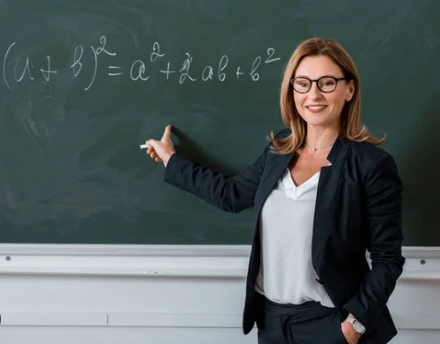
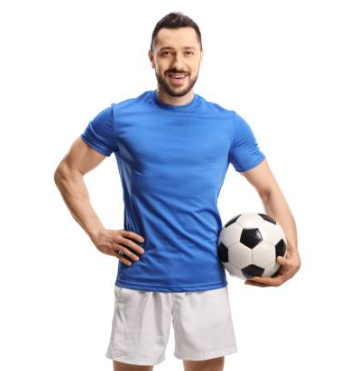
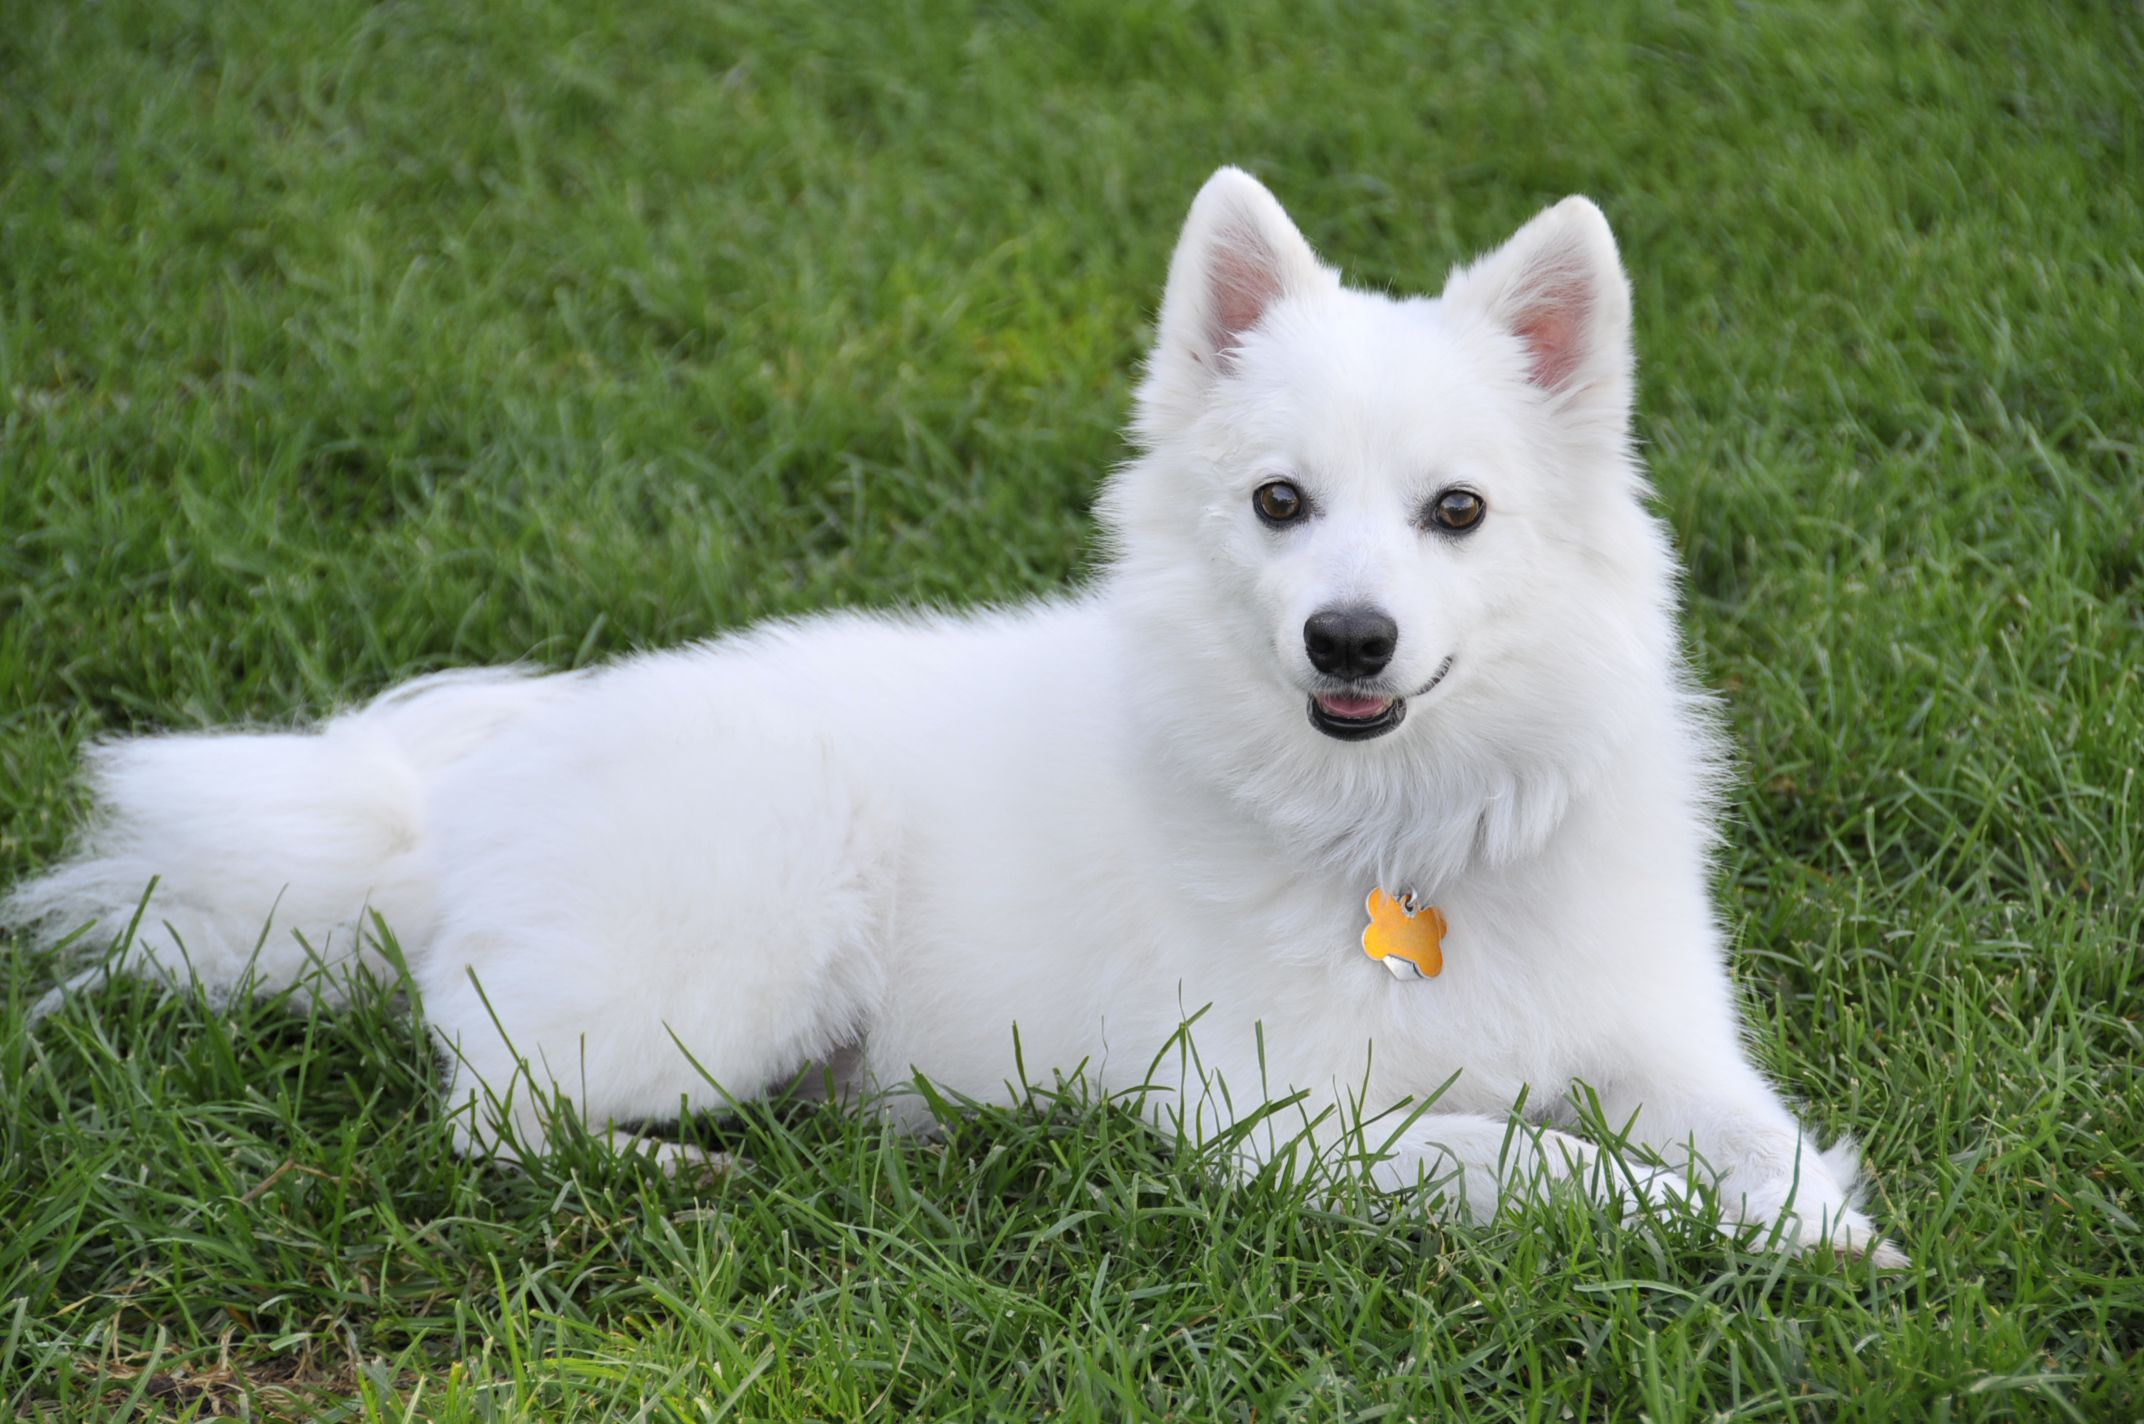
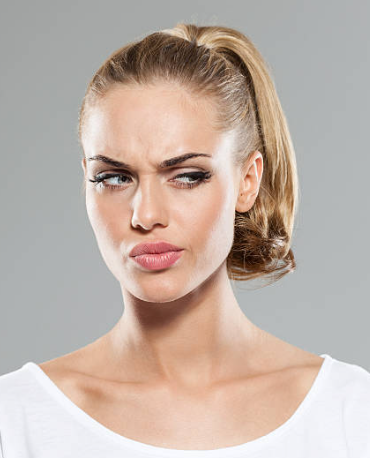
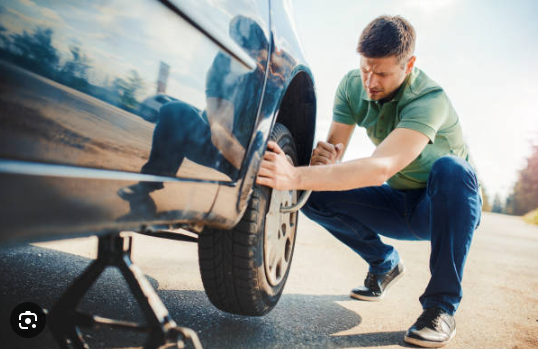
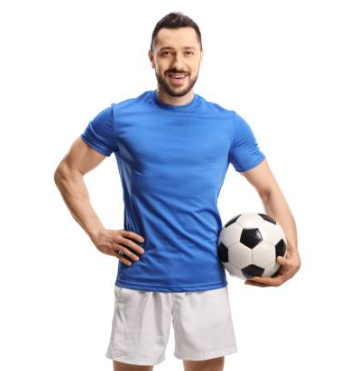
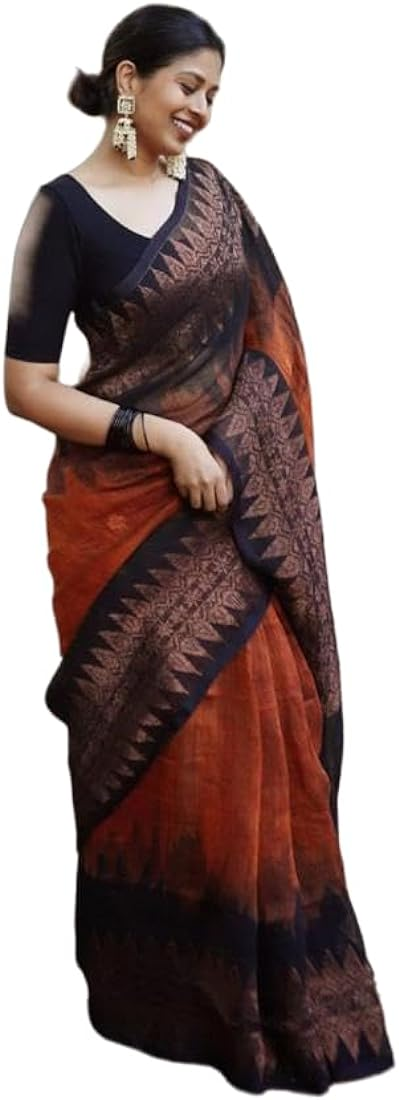

In [ ]:
from IPython.display import HTML
from PIL import Image
import base64

def image_to_base64(row, image_path='/content/sample_data/images/'):
    with open(f"{image_path}{row['image_name']}", 'rb') as f:
        encoded_string = base64.b64encode(f.read()).decode()
    return f"<img src='data:image/png;base64,{encoded_string}' width=100>"

def create_image_url(row, image_folder='sample_data/images/'):
    return f"<img src='{image_folder}{row['image_name']}' width=100>"

df_results['Image'] = df_results.apply(image_to_base64, axis=1)

styles="""
        <style>
            table, th, td {
                border: 1px solid black;
                width: 150px;
            }
            th:first-child, td:first-child  {
              width: 10px;
            }
        </style>
        """

HTML(styles + df_results.to_html(escape=False))